## 이미지 CNN 분석 과정
1. 데이터 탐색, 전처리

2. 모델 구성

3. 훈련

4. 평가

5. 예측하기

In [1]:
# 관련 import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import os, re, glob  
import time
import cv2  
from sklearn.model_selection import train_test_split 
from PIL import Image
import os, glob, numpy as np
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model,Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.데이터 탐색, 전처리 
- train, test set 나누어서 라벨링함.

In [ ]:
#Image와 카테고리를 X, Y값으로 나누기
    # ex) ./new1/[nike, adidas, convers,등등]
imagePath = "/content/drive/MyDrive/Bit MiniProject/Shoes"

#구분 할 이미지의 브랜드명 * 신발 카테고리 갯수 만큼 list 생성
categories = ['Other-Sneakers','나이키-Running',"반스-Canvas", "슈펜-Canvas","아디다스-Running","아식스-Running","엑셀시오르-Canvas","컨버스-Canvas","프로스펙스-Running",'휠라-Running'] # 카테고리가 됨
nb_classes = len(categories)

# 사진 용량 감소를 위해서 크기 조정
image_w = 64
image_h = 64

X = []
Y = []

# 카테고리 인덱스 라벨링
for idx, cate in enumerate(categories):        
  # 카테고리별로 돌면서 0으로 초기화, categories의 인덱스 위치에 1을 넣어준다(OneHotEncoding)
  label = [0 for i in range(nb_classes)]
  label[idx] = 1

  image_dir = imagePath + '/' + cate + '/'
  files = glob.glob(image_dir+'/*.*')
  img_num = 0

# 파일 별로 64 * 64의 이미지로 줄어주고 255로 나누어 정규화를 진행해 라벨별로 categorie에 저장 한다.
  for top, dir, f in os.walk(image_dir): 
        for filename in f:
            print(image_dir+filename)  
            img = cv2.imread(image_dir+filename)  
            img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])  
            X.append(img/256)  
            Y.append(label)  

X = np.array(X)  
Y = np.array(Y)  

X_train, X_test, Y_train, Y_test = train_test_split(X,Y)  
xy = (X_train, X_test, Y_train, Y_test) 


#생성된 데이터셋을 저장할 경로와 파일이름 지정
np.save("./imageDataList.npy", xy)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1193A071-101_7.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1193A071-101_6.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_1.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_2.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_3.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_5.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_4.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_8.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_6.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_7.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1012A504-400_9.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Running/1191A149-400_0.jpg
/content/drive/MyDrive/Bit MiniProject/Shoes/아식스-Run

In [5]:
#저장된 npy의 파일 data load 하기
X_train, X_test, Y_train, Y_test = np.load('/content/drive/MyDrive/Bit MiniProject/Shoes_imageDataList/imageDataList.npy', allow_pickle=True)

### 데이터 확인
- shpae : total(11208)개 , 픽셀(64,64) , RGB(3)데이터
- 7번째 사진 파일 나이키 사진
- label 값은 1번 '나이키-Running'

In [ ]:
# 전체 데이터 갯수와 shape 확인하기
print(X_train.shape)
print(X_train.shape[0])

(11538, 64, 64, 3)
11538


In [ ]:
# label[2] = 반스 컨버스의 값
Y_train[27]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

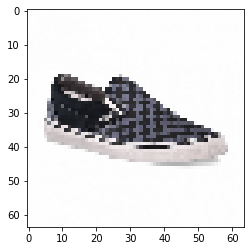

In [ ]:
# 실제 나이키running 확인하기
plt.imshow(X_train[27])

In [ ]:
print(len(X_train)) , print(len(X_test))

11538
3847


(None, None)

# 2.모델 구성

In [ ]:
#기존 모델 불러오기
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Bit MiniProject/Shoes_imageDataList/shoes_model.h5')


In [6]:
# 모델 생성

#Sequence 클래스 생성
model = Sequential()

# 3*3 크기의 컨볼루션 레이어 32개의 필터를 생성 , input_shape 는 64,64,3 이니 [3] 을 설정
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
#maxpooling을 통해 영역 셀값의 최댓값(주요값) 을 채택한다. 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


#Fully Connection
#2D로 되어있는 임베딩을 1차원 단일 벡터로 변환함
model.add(Flatten())
# 인풋과 아웃풋 사이에 히든레이어를 둔다.   
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
#노드의 수(카테고리의 수)
model.add(Dense(10, activation='softmax'))  
# loss 함수로는 3개 이상의 label값, OneHotEncoding 되어있어 categorical_crossentropy사용
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'
# 모델 저장    
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
model_path = model_dir + '/multi_img_classification.model'


In [7]:
#모델 저장하기
from keras.models import load_model
model.save('shoes_model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

## 컨볼루션 레이어 시각화


In [ ]:
layer = tf.keras.layers.Conv2D(filters=5, kernel_size=3)
# 데이터를 4 차원으로 만들어 주어야함
new_X_train = X_train[27][tf.newaxis,...]
output = layer(new_X_train)
output.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([1, 62, 62, 5])

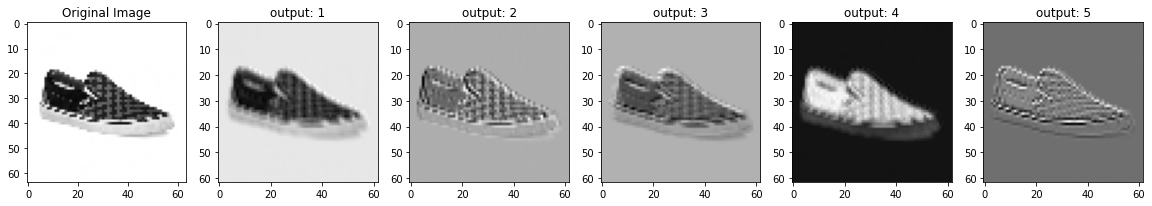

In [ ]:
# Convolution 레이어 plot 그리기
_, axes = plt.subplots(nrows=1 , ncols=6, figsize=(20,10))

axes[0].imshow(new_X_train[0,...,0],cmap='gray')
axes[0].set_title('Original Image')

for idx, ax in enumerate(axes[1:]):
  ax.set_title('output: {}'.format(idx +1))
  ax.imshow(output[0,...,idx],cmap='gray')
plt.show()

## ReLu 함수 그리기

In [ ]:
act_layer = tf.keras.layers.ReLU()
act_output = act_layer(output) # 합성곱의 결과가 활성화 레이어로 들어감
act_output.shape

TensorShape([1, 62, 62, 5])

In [ ]:
np.min(act_output),np.max(act_output)

(0.0, 1.0819315)

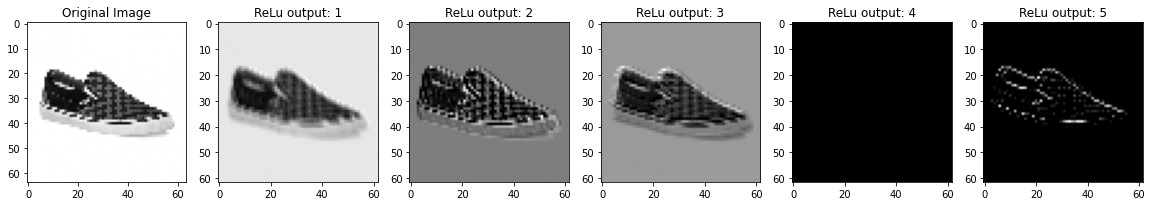

In [ ]:
_, axes = plt.subplots(nrows=1 , ncols=6, figsize=(20,10))

axes[0].imshow(new_X_train[0,...,0],cmap='gray')
axes[0].set_title('Original Image')

for idx, ax in enumerate(axes[1:]):
  ax.set_title('ReLu output: {}'.format(idx +1))
  ax.imshow(act_output[0,...,idx],cmap='gray')
plt.show()

## Maxplot 그리기

In [ ]:
pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding="SAME")
  # 2행 2열의 pool을 만들어 가장 큰값을 넣어 예측 한다,
pool_output = pool_layer(act_output)

pool_output.shape

TensorShape([1, 31, 31, 5])

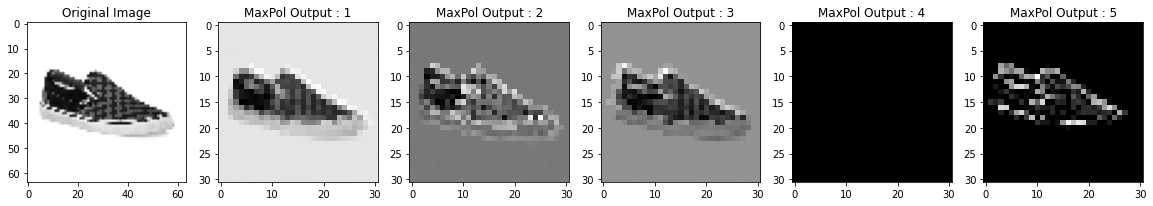

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 10))
  # 1행, 6열의 그래프를 가로 가로 20사이즈 10의 간격으로 그려라

axes[0].imshow(new_X_train[0, ..., 0], cmap='gray')
  #image data에서 ... 사이에 데이터만 gray 색상으로 그려라
axes[0].set_title("Original Image")
  # title 이름을 정해라

for idx, ax in enumerate(axes[1:]):
    #idx, ax 를 1부터 있는데 까지 그려라
  ax.set_title("MaxPol Output : {}".format(idx + 1))
  ax.imshow(pool_output[0, ..., idx], cmap='gray')

plt.show()

# 3.훈련
  - early stopping : 6번 이상 로스율에 변화가없으면 훈련을 멈춘다.

In [ ]:
#Callback Function 설정
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [ ]:
# 30개의 데이터를 가지고 50번의 학습 단위 설정
history = model.fit(X_train, Y_train, 
                    batch_size=30, 
                    epochs=50, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
385/385 [==============================] - ETA: 0s - loss: 1.8054 - accuracy: 0.4079
Epoch 00001: val_loss improved from inf to 1.52716, saving model to ./model/multi_img_classification.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/multi_img_classification.model/assets
385/385 [==============================] - 5s 12ms/step - loss: 1.8054 - accuracy: 0.4079 - val_loss: 1.5272 - val_accuracy: 0.4975
Epoch 2/50
379/385 [============================>.] - ETA: 0s - loss: 1.3530 - accuracy: 0.5462
Epoch 00002: val_loss improved from 1.52716 to 1.23824, saving model to ./model/multi_img_classification.model
INFO:tensorflow:Assets written to: ./model/multi_img_classification.model/assets
385/385 [==============================] - 4s 11ms/step - loss

# 4.평가
- 사진 데이터를 모을때 사진의 디테일 사진이 많아서 로스율이 많아진 것으로 추정 된다.
- 신발 쉐잎의 사진을 좀더 모아서 train을 한다면 accuracy가 올라가고 loss가 감소 될 것으로 예상됨.

In [ ]:
print("정확도 : %.4f" % (model.evaluate(X_test, Y_test)[1]))

121/121 [==============================] - 1s 4ms/step - loss: 0.8218 - accuracy: 0.7406
정확도 : 0.7406


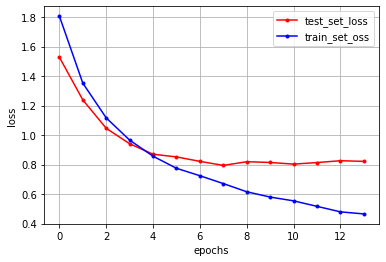

In [ ]:
import matplotlib.pyplot as plt
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='test_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

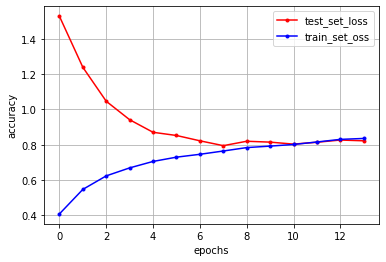

In [ ]:
import matplotlib.pyplot as plt
y_vloss = history.history['val_loss']
y_loss = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='test_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

# 4.예측하기

- 예측할 운동화 사진 예측실행.
- 시간이 오래 걸려 64 * 64 로해서 정확도가 조금 떨어진다.

In [ ]:
# 테스트할 폴더
caltech_dir = "/content/drive/MyDrive/Bit MiniProject/test"
image_w = 64
image_h = 64

#폴더 안에 있는 파일 for문으로 설정
X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X) # file name 를 저장한다
# model = load_model('/content/model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0
categories = ['나이키-Running',"반스-Canvas", "슈펜-Canvas","아디다스-Running","아식스-Running","엑셀시오르-Canvas","컨버스-Canvas","프로스펙스-Running",'휠라-Running'] # 카테고리가 됨

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = '나이키-Running'
    elif pre_ans == 1: pre_ans_str = "반스-Canvas"
    elif pre_ans == 2: pre_ans_str = "슈펜-Canvas"
    elif pre_ans == 3: pre_ans_str = "아디다스-Running"
    elif pre_ans == 4: pre_ans_str = "아식스-Running"
    elif pre_ans == 5: pre_ans_str = "아디다스-Running"
    elif pre_ans == 6: pre_ans_str = "엑셀시오르-Canvas"
    elif pre_ans == 7: pre_ans_str = "컨버스-Canvas"
    elif pre_ans == 8: pre_ans_str = "프로스펙스-Running"
    elif pre_ans == 8: pre_ans_str = '휠라-Running'

    if i[0] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[5] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[6] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[7] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")
    if i[8] >= 0.8: print("해당 "+filenames[cnt].split("//")[0]+"이미지는 \n"+pre_ans_str+"로 추정됩니다.")

    cnt += 1

    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.

[1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
0
해당 /content/drive/MyDrive/Bit MiniProject/test/컨버스4.jpg이미지는 
나이키-Running로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/MyDrive/Bit MiniProject/test/반스.jpg이미지는 
슈펜-Canvas로 추정됩니다.
[0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
7
해당 /content/drive/MyDrive/Bit MiniProject/test/컨버스1.jpg이미지는 
컨버스-Canvas로 추정됩니다.
[0.000 0.000 0.999 0.000 0.001 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/MyDrive/Bit MiniProject/test/아디다스.jpg이미지는 
슈펜-Canvas로 추정됩니다.
[0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
7
해당 /content/drive/MyDrive/Bit MiniProject/test/컨버스.jpg이미지는 
컨버스-Canvas로 추정됩니다.
[0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000]
7
해당 /content/drive/MyDrive/Bit MiniProject/test/컨버스1.jpeg이미지는 
컨버스-Canvas로 추정됩니다.
[0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
2
해당 /content/drive/MyDrive/Bit MiniProject/test/컨버

## 전이학습 모델 생성 후 test

- 예측률을 높히기 위해 미리학습된 모델을 불러 사용
- 학습데이터에 적절하지 않은 사진이 많아서 로스율이 더 높아진것으로 예측 됐다.


In [ ]:
from keras.applications.vgg16 import VGG16
#weigenet: 로딩할 가중치.  include_top : 출력 레이어를 포함할 것인지 여부, 개별 문제에 적합되어있으면 불필요
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))
transfer_model.trainable =False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
from tensorflow.keras import models , optimizers

In [ ]:
model2 = models.Sequential()
model2.add(transfer_model)
model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dense(10,activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 14,846,474
Trainable params: 131,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# 컴파일
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history2 = model2.fit(X_train, Y_train, 
                    batch_size=30, 
                    epochs=50, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
385/385 [==============================] - ETA: 0s - loss: 1.4592 - accuracy: 0.5231
Epoch 00001: val_loss did not improve from 0.79433
385/385 [==============================] - 8s 22ms/step - loss: 1.4592 - accuracy: 0.5231 - val_loss: 1.2389 - val_accuracy: 0.5976
Epoch 2/50
383/385 [============================>.] - ETA: 0s - loss: 1.0759 - accuracy: 0.6471
Epoch 00002: val_loss did not improve from 0.79433
385/385 [==============================] - 8s 21ms/step - loss: 1.0755 - accuracy: 0.6471 - val_loss: 1.0904 - val_accuracy: 0.6405
Epoch 3/50
385/385 [==============================] - ETA: 0s - loss: 0.9307 - accuracy: 0.6926
Epoch 00003: val_loss did not improve from 0.79433
385/385 [==============================] - 8s 21ms/step - loss: 0.9307 - accuracy: 0.6926 - val_loss: 1.0313 - val_accuracy: 0.6722
Epoch 4/50
384/385 [============================>.] - ETA: 0s - loss: 0.8407 - accuracy: 0.7170
Epoch 00004: val_loss did not improve from 0.79433
385/385 [=======

In [ ]:
print("정확도 : %.4f" % (model2.evaluate(X_test, Y_test)[1]))

121/121 [==============================] - 2s 15ms/step - loss: 0.9829 - accuracy: 0.6964
정확도 : 0.6964


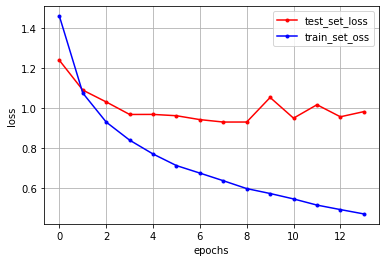

In [ ]:
import matplotlib.pyplot as plt
y_vloss = history2.history['val_loss']
y_loss = history2.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='test_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

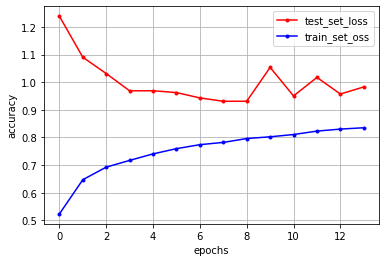

In [ ]:
import matplotlib.pyplot as plt
y_vloss = history2.history['val_loss']
y_loss = history2.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='test_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

xxxx실패한 것

In [ ]:
# 이미지제너레이터 
# 크롤링한 이미지 , 세부 신발사진 , 세부 사진 비율이 똑같아, 로스율이 많을 것으로 예측됨
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = '다중분류클래시피케이션')
test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = '다중분류클래시피케이션')
classifier.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 25,
                         validation_data = test_set,
                         nb_val_samples = 2000)

In [ ]:
# 각 카테고리 별로 사진 늘리기
 
filename_in_dir = []
fname = ('*.*')
for root, dirs, files in os.walk('/content/drive/MyDrive/Bit MiniProject/Shoes/'):
    for  fname in files:
        full_fname = os.path.join(root, fname)
        filename_in_dir.append(full_fname)
 
for file_image in filename_in_dir:
    print file_image
    img = load_img(file_image) 
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
 
    i = 0
 
    for batch in data_datagen.flow(x,save_to_dir='', save_prefix='', save_format='jpg'):
        i += 1
        if i > 5:
            break

SyntaxError: ignored

In [ ]:
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
latent_vector_model = tf.keras.Model(inputs=model.input, outputs=model.layers[10].output)
latent_vector = latent_vector_model.predict(X_train)
print(latent_vector.shape)
print(latent_vector[6])

(11208, 256)
[0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 2.422
 0.000 0.000 0.000 0.000 0.282 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.209 0.335 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.483 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.489 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 2.542 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.272 0.000 0.000
 0.000 0.000 0.000 0.464 0.000 0.000 1.579 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 1.184 0.000 0.000 0.000 0.000 0.000 3.391 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0